In [2]:
import pandas as pd # Pour le dataframe
import numpy as np # Pour la normalisation et calculs de moyenne
import matplotlib.pyplot as plt # Pour la visualisation

from PIL import Image

import librosa # Pour l'extraction des features et la lecture des fichiers wav
import librosa.display # Pour récupérer les spectrogrammes des audio
import librosa.feature

import os # C'est ce qui va nous permettre d'itérer sur les fichiers de l'environnement de travail

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV # Split de dataset et optimisation des hyperparamètres
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.ensemble import GradientBoostingClassifier # XGBoost
from sklearn.neighbors import KNeighborsClassifier # k-NN
from sklearn.svm import SVC # SVM
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, zero_one_loss, classification_report # Métriques pour la mesure de performances
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf # Pour le reseau de neurones simple et pour le CNN

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam
from keras.utils import to_categorical

from xgboost import XGBClassifier
from pprint import pprint

In [3]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']

On commence par créer un dictionnaire avec tous les fichiers wav pour chaque genre musical.

On commence par initialiser le dictionnaire avec les clés qui sont les noms des genres. On met autant de listes vides qu'il n'y a de genres. Nous allons ensuite itérer sur les musiques genre par genre pour remplir ces listes.

In [4]:
audio_files = {}

for g in genres:
  audio_files[g] = []

In [5]:
for g in genres:
  for audio in os.listdir(f'./dataset/genres_original/{g}'):
    audio_files[g].append(librosa.load(f'./dataset/genres_original/{g}/{audio}')[0])

A ce stade nous avons un dictionnaire *audio_files* dont les clés sont les noms des genres et dont les valeurs sont les arrays correspondant à une musique donnée.

## ZCR : Zero Crossing Rate

Le ZCR est un indicateur proportionnel au taux de changement de signe d'un signal musical. Il est très utilisé pour la reconnaissance vocale et semble être un critère intéressant pour faire de la classification de musiques.

L'expression est donnée par :

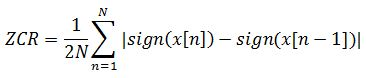

## Spectral centroid

Le spectral centroid est une métrique utilisée pour caractériser les spectres des musiques. Il s'agit d'un indicateur géométrique de la position du centre de masse du spectre d'un son.

Dans l'étude des timbres musicaux on parle parfois de *brightness*, beaucoup considérent cette caractéristique comme étant l'un des facteurs les plus discriminants entre des musiques. C'est un indicateur de la quantité de fréquences hautes qui composent le son. Et le spectral centroid constitue un moyen fiable pour mesurer cette caractéristique.

Sa formule est simplement la moyenne ponderée des signaux par des coefficients *x(i)* :

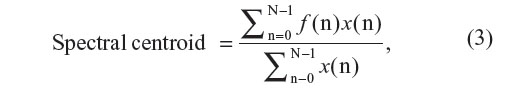

## MFCC : Mel-Frequency Cepstral Coefficients

Les MFCC sont des coefficients cepstraux qui correspondent à une transformation sinusoïdale de la puissance d'un signal. Le calcul de ces coefficients se fait suivant ces différentes étapes :
*   Calcul de la transformée de Fourier de la trame à analyser

*   Pondération du spectre d'amplitude (ou de puissance selon les cas) par un banc de filtres triangulaires espacés selon l'échelle de Mel

*   Calcul de la transformée en cosinus discrète du log-mel-spectre


Source : [Wikipédia](https://fr.wikipedia.org/wiki/Cepstre#MFCC)

## Spectral Rolloff Point

Cette feature est une mesure de l'asymétrie à droite d'un spectre sonore. Elle est utilisée par exemple pour différencier des paroles chantées et des paroles normales (cf Scheirer & Slaney).

## Construction du pipeline

Maintenant que nous avons présentés toutes les features que l'on a considérer, construisons un pipeline pour créer une base d'apprentissage. Toutes ces features sont facilement calculables avec la librairie Python Librosa.

Ce pipeline nous servira aussi pour essayer nos modèles sur des fichiers musicaux externes (YouTube par exemple).

In [10]:
def audio_pipeline(audio):
  features = []

  # Calcul du ZCR
  zcr = librosa.zero_crossings(audio)
  features.append(sum(zcr))

  # Calcul de la moyenne du Spectral centroid

  spectral_centroids = librosa.feature.spectral_centroid(y=audio)[0]
  features.append(np.mean(spectral_centroids))

  # Calcul du spectral rolloff point

  rolloff = librosa.feature.spectral_rolloff(y=audio)
  features.append(np.mean(rolloff))

  # Calcul des moyennes des MFCC

  mfcc = librosa.feature.mfcc(y=audio)

  for x in mfcc:
    features.append(np.mean(x))


  return features

On écrit les noms des features dans les colonnes d'un dataframe :

In [11]:
column_names = ['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']

In [12]:
df = pd.DataFrame(columns = column_names)

In [13]:
i = 0
for g in genres:
  for music in audio_files[g]:
    df.loc[i] = audio_pipeline(music)+[g]
    i+=1

In [15]:
df.shape

(949, 24)

On exporte ce dataframe en csv pour pouvoir l'utiliser sans refaire toute la partie extraction de features.

In [16]:
df.to_csv('musicColab.csv', index = False)

Maintenant nos données sont disponibles au format csv, c'est beaucoup facile et léger de les avoir dans ce format.

## Etude de la qualité des features

Notre dataframe est déjà importé mais récrivons les commandes qui serviront désormais de point de désormais :

In [32]:
df = pd.read_csv("musicLabo.csv")

On peut visualiser un extrait du dataframe :

In [33]:
df.head()

,zcr,spectral_c,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,55032,1784.122641,3805.723030,-113.598820,121.57067,-19.162262,42.363937,-6.362266,18.621931,-13.699734,...,8.802088,-3.669941,5.744676,-5.162783,0.751706,-1.687854,-0.408730,-2.302677,1.222467,blues
1,37140,1530.261767,3550.713616,-207.523830,123.98514,8.947019,35.867150,2.909594,21.519472,-8.556514,...,5.377876,-2.234492,4.220704,-6.010686,0.929294,-0.728403,0.296872,-0.282430,0.530644,blues
2,50564,1552.832481,3042.410115,-90.757164,140.44087,-29.084547,31.686693,-13.976547,25.753752,-13.664990,...,5.791247,-8.901967,-1.080160,-9.226244,2.448304,-7.724839,-1.819024,-3.440458,-2.238128,blues
3,22078,1070.153418,2184.879029,-199.575130,150.08610,5.663404,26.855282,1.770071,14.232647,-4.827845,...,6.078081,-2.478445,-1.081587,-2.874454,0.773994,-3.324069,0.636311,-0.615968,-3.405046,blues
4,67226,1835.128513,3579.957471,-160.354170,126.20948,-35.581394,22.139256,-32.473550,10.850701,-23.350070,...,-2.810499,-6.934471,-7.553875,-9.167669,-4.515863,-5.451786,-0.915952,-4.408018,-11.704385,blues


### Variances

On peut commencer par calculer les variances pour chaque variable. Ensuite, en fixant un seuil minimal, on pourra garder uniquement les features qui contiennent assez d'informations.

In [43]:
selector = VarianceThreshold(threshold=(0.2))
selected_features = selector.fit_transform(df[['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                                              'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                                              'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                                              'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']])

pd.DataFrame(selected_features)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,55032.0,1784.122641,3805.723030,-113.598820,121.570670,-19.162262,42.363937,-6.362266,18.621931,-13.699734,...,-8.326061,8.802088,-3.669941,5.744676,-5.162783,0.751706,-1.687854,-0.408730,-2.302677,1.222467
1,37140.0,1530.261767,3550.713616,-207.523830,123.985140,8.947019,35.867150,2.909594,21.519472,-8.556514,...,-5.558824,5.377876,-2.234492,4.220704,-6.010686,0.929294,-0.728403,0.296872,-0.282430,0.530644
2,50564.0,1552.832481,3042.410115,-90.757164,140.440870,-29.084547,31.686693,-13.976547,25.753752,-13.664990,...,-13.125314,5.791247,-8.901967,-1.080160,-9.226244,2.448304,-7.724839,-1.819024,-3.440458,-2.238128
3,22078.0,1070.153418,2184.879029,-199.575130,150.086100,5.663404,26.855282,1.770071,14.232647,-4.827845,...,-3.200026,6.078081,-2.478445,-1.081587,-2.874454,0.773994,-3.324069,0.636311,-0.615968,-3.405046
4,67226.0,1835.128513,3579.957471,-160.354170,126.209480,-35.581394,22.139256,-32.473550,10.850701,-23.350070,...,-13.084959,-2.810499,-6.934471,-7.553875,-9.167669,-4.515863,-5.451786,-0.915952,-4.408018,-11.704385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,59125.0,2008.174521,4253.623647,-153.630050,109.904785,-23.091644,59.014496,-7.520482,19.728552,-16.488035,...,-12.378634,12.347538,-12.310061,5.780296,-10.265627,1.803152,-13.293470,2.483825,-6.716792,-1.198403
995,64738.0,2006.827265,4149.171791,-142.416210,116.205460,-32.160263,49.111510,-8.389906,22.885155,-18.317211,...,-12.998068,14.083412,-16.392958,4.162846,-4.373984,3.736334,-10.860102,1.877821,-7.468264,-2.791855
996,80748.0,2077.565822,4031.530224,-124.989655,115.182340,-47.985886,52.820343,-13.493603,21.751259,-12.417660,...,-16.045313,10.477310,-17.955710,1.215155,-11.527904,1.838067,-12.851801,3.445699,-12.589926,-2.104325
997,32293.0,1398.649505,3015.597697,-225.033360,123.657265,-9.745125,56.613846,10.421820,20.643210,-10.258778,...,-9.006475,7.688631,-10.083799,-0.252279,-5.282494,-2.810897,-4.421513,1.558363,-5.046078,-3.587599


### Valeurs manquantes et répartition des classes

Il n'y a aucune valeur manquante puisque les features calculées sont toujours définies quelque soit le fichier audio.

Dans notre cas la base d'entraînement est parfaitement équilibrées puisqu'on a 100 musiques pour chacun des 10 genres representés.

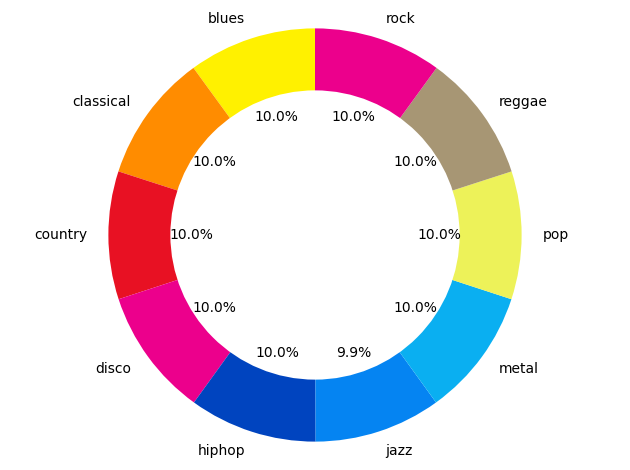

In [36]:
y = df['label']
values = np.unique(y,return_counts=True)[1]

labels = genres
sizes = values

# Choix des couleurs

colors =['#fff100','#ff8c00','#e81123','#ec008c','#0044bf','#0584f2','#0aaff1','#edf259','#a79674','#ec008c']

# Construction du diagramme et affichage des labels et des #fréquences en pourcentage

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

# Tracé du cercle au milieu

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Affichage du diagramme

ax1.axis('equal')
plt.tight_layout()
plt.show()

Cette vérification est importante car lorsque les classes sont trop déséquilibrées, les modèles risquent d'être biaisés et il faut ajuster les poids de chaque classe pour éviter ça.

Ces premières vérifications nous permettent de dire que la qualité de nos données est plutôt bonne et nous permettra d'avoir des résultats exploitables.

# Construction des différents modèles

Pour répondre à la problèmatique que nous nous sommes posés nous avons choisis de mesurer les performances obtenus avec plusieurs modèles différents :



*   Support vector machines
*   k nearest neighbours
*   Random forest
*   XGBoost
*   Réseau de neurones simple
*   CNN sur les images des spectrogrammes



On peut déjà construire nos ensembles d'entraînements et de test qui seront à peu de choses près les mêmes à chaque fois :

In [37]:
import random

In [38]:
X = df[['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
           'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
           'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
           'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']]

y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Réseaux de neurones

Les réseaux de neurones sont des architectures dans lesquelles des neurones sont organisés en couches successives connectées de proche en proche. Parmi les couches, on distingue la couche d’entrée, les couches cachées et la couche de sortie.

Afin de s'en convaincre définitivement, on décide d'utiliser un réseau de neurones.

Notre réseau sera constitué de trois couches (entrée, cachée, sortie).

Avant de commencer, on prépare à nouveau les données en distinguant l'échantillon d'entrainement de l'échantillon de test.

In [51]:
features = pd.read_csv('musicLabo.csv')
# features = df
# One-hot encode
labels = pd.get_dummies(features['label'])

print(labels)
# enleve les labels des features
features = features.drop('label', axis = 1)
# sauvegarde la liste des features
feature_list = list(features.columns)
# conversion en numpy array
features = np.array(features)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state = 0)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

# scaling
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.transform(test_features)

     blues  classical  country  disco  hiphop   jazz  metal    pop  reggae  \
0     True      False    False  False   False  False  False  False   False   
1     True      False    False  False   False  False  False  False   False   
2     True      False    False  False   False  False  False  False   False   
3     True      False    False  False   False  False  False  False   False   
4     True      False    False  False   False  False  False  False   False   
..     ...        ...      ...    ...     ...    ...    ...    ...     ...   
994  False      False    False  False   False  False  False  False   False   
995  False      False    False  False   False  False  False  False   False   
996  False      False    False  False   False  False  False  False   False   
997  False      False    False  False   False  False  False  False   False   
998  False      False    False  False   False  False  False  False   False   

      rock  
0    False  
1    False  
2    False  
3    False 

### Modéle

Le modèle comporte 23 neurones sur sa couche d'entrée (correspondant aux nombres des features), 161 neurones sur sa couche cachée (résultats du tuning) et 10 neurones sur sa couche de sortie (correspondant au nombre de genres possibles).

In [95]:
# création du modèle
model = Sequential()
model.add(Dense(161, input_dim=23, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

# fit le modèle
history = model.fit(train_features, train_labels, epochs=200, batch_size=20, verbose=0)

print(test_features[0])
# prédiction
predictions = model.predict(test_features)

print(predictions)
# evaluation du modèle
_, accuracy = model.evaluate(test_features, test_labels, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

[ 1.81222696  2.16402512  2.04852342  1.00754506 -1.52873198  1.54560578
 -1.42073972  0.95807561 -0.54448274  1.32890243 -0.9907809   1.56181516
 -0.33623927  0.49629112 -0.4279042   0.44660933 -0.40775823  0.83508388
 -0.66626895  0.39952657 -0.41056767  0.72970192  0.18492583]
8/8 [==============================] - 0s 936us/step
[[3.4320568e-27 4.2572994e-15 2.4851002e-07 ... 9.9954611e-01
  1.3961274e-07 1.3121608e-07]
 [7.5018823e-01 4.9268304e-13 6.3753920e-05 ... 4.5956236e-20
  2.7808736e-07 1.5530346e-01]
 [3.1290514e-05 6.4156602e-10 1.1829723e-04 ... 3.1705074e-02
  7.8862727e-01 1.7361590e-04]
 ...
 [2.1958703e-16 2.8230642e-07 2.3225644e-04 ... 9.7490172e-04
  7.2214357e-03 1.0833141e-01]
 [7.9382610e-01 5.6456433e-11 9.6117973e-04 ... 9.5062102e-18
  7.9033576e-04 3.0714895e-03]
 [6.7951580e-05 9.1710923e-08 6.2368213e-06 ... 1.9164094e-17
  2.5617449e-06 7.9232657e-01]]
Accuracy: 67.60


C'est jusqu'ici le meilleur modèle! Néanmoins, afin de nuancer les résultats, on remarque que les différences de performances entre les meilleurs modèles sont minimes. A ce niveau, on serait même tenter d'affirmer que rajouter un couche supplémentaire n'améliorerait pas le score, et que la performance maximale atteignable sur ce jeu de données tourne autour de 60%.

In [125]:

# Load and preprocess the audio file
def preprocess_audio(file_path):
    audio, _ = librosa.load(file_path, sr=None)
    
    # Apply the same feature extraction and scaling as you did during training
    features = audio_pipeline(audio)
    scaled_features = sc.transform([features]) 
    
    return scaled_features

# Make predictions on the preprocessed audio
def predict_top_genres(file_path, top_n=3):
    scaled_features = preprocess_audio(file_path)
    predicted_probabilities = loaded_model.predict(scaled_features)
    # top_n_indices = np.argsort(predicted_probabilities[0])[::-1][:top_n]
    # top_n_genres = [genres[idx] for idx in top_n_indices]
    # prediction_percentages = [predicted_probabilities[0][idx] * 100 for idx in top_n_indices]
    # return top_n_genres, prediction_percentages

# Provide the path to the audio file you want to classify
audio_file_path = './dataset/to_check/sound/blues/blues.00000.wav'
top_genres, prediction_percentages = predict_top_genres(audio_file_path)

for i, genre in enumerate(top_genres):
    print( i+1, genre,'{:.2f}%'.format(prediction_percentages[i]))


AttributeError: 'StandardScaler' object has no attribute 'mean_'

## Approche plus éxotique : CNN sur les images des spectres

Dans un article de Towards data science sur ce problème une approche assez inhabituelle a été suggérée par l'auteur, nous avons décidé de l'implémenter pour vérifier si cela peut fonctionner.

L'idée est d'entraîner le modèle de classification non pas sur les features que nous avons selectionnées mais sur les images représentants le spectre de la musique. Pour cela nous allons d'abord construire un pipeline pour récupérer les spectres audio et encoder les images crées. Nous ferons la classification des images avec des réseaux de convolutions.

### Introduction aux CNN

L'utilisation de réseaux de neurones convolutionnels représente la meilleure approche lorsqu'il s'agit de faire de la classification d'images.

### Création des images

Dans la cellule ci-dessous, nous assoçions tous les fichiers audio à leur spectrogramme. Pour cela nous devons itérer sur ces fichiers, ploter leurs spectrogrammes respectifs et sauvegarder l'image dans un dossier que nous avons créé au préalable.

Tous les spectrogrammes seront ensuite accessibles depuis le dictionnaire *audio_files* :

In [ ]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']

audio_files = {}

for g in genres:
  audio_files[g] = []

In [ ]:
for g in genres:
  for audio in os.listdir(f'./genres/{g}'):
    audio_files[g].append(librosa.core.load(f'./genres/{g}/{audio}'))

### Preprocessing

On peut maintenant stocker toutes les images sous forme de matrices numpy dans un vecteur X :

Nous allon maintenant mettre en ordre nos données d'entraînement. On doit avoir un array que nous appelerons *X* (pour ne pas confondre avec le précédent X) constitué de toutes les matrices des images, ainsi qu'un array appelé *y_cnn* avec tous les labels.

In [ ]:
mel_specs = []

for g in genres:

  for audio in audio_files[g]:

    y = audio[0]
    sr = audio[1]

    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)

# On modifie la taille des images 128 x 660 en gardant les paramètres proposés dans l'article initial
    if spect.shape[1] != 660:
      spect.resize(128,660, refcheck=False)

    mel_specs.append(spect)

X = np.array(mel_specs)

On peut maintenant créer le vecteur des labels *y_cnn*, pour l'instant nos images sont dans l'ordre la construction de y_cnn est triviale :

In [ ]:
y_cnn = []

for i in range(len(genres)):
  y_cnn += 100*[i] # On a 100 images pour chaque genre

y_cnn = np.array(y_cnn)

Pour pouvoir utiliser y_cnn il faut la transformer en variables catégoriques par un encodage One-Hot, scikit-learn permet de le faire très facilement.

On split ensuite nos données en données de test et données d'entraînements :

In [ ]:
y_cnn = to_categorical(y_cnn)

x_cnn_train, x_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X, y_cnn)

On pense à normaliser les données, c'est important pour l'analyse d'images :

In [ ]:
x_cnn_train /= -80
x_cnn_test /= -80

A présent on met en forme nos données pour l'entraînement :

In [ ]:
x_cnn_train = x_cnn_train.reshape(x_cnn_train.shape[0], 128, 660, 1)
x_cnn_test = x_cnn_test.reshape(x_cnn_test.shape[0], 128, 660, 1)

A ce stade nous avons bien deux arrays X et y_cnn. X contient toutes les matrices représentants les images des spectrogrammes et y_cnn contient les labels pour chaque image.

Vérifions les tailles de x_cnn et y_cnn pour être sur qu'il n'y a pas de problème :

In [ ]:
print(x_cnn_train.shape)
print(y_cnn_train.shape)

(750, 128, 660, 1)
(750, 10)


### Construction du CNN

Construisons notre modèle :

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(128,660,1)))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64,
                 kernel_size=(3, 3),
                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

Avant de lancer l'entraînement du réseau, voyons un résumé des couches que l'on a :

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 126, 658, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 329, 32)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 327, 64)       18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 163, 64)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 163, 64)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 161, 32)       18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 80, 32)       

On compile le modèle en selectionnant la *categorical crossentropy* comme perte avec l'optimiseur ADAM.

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

On peut à présent commencer l'entraînement. Nous le faisons sur Google Colab pour pouvoir profiter d'un traitement parallèle sur GPU, ce qui représente un gain de temps considérable.

In [ ]:
history = model.fit(x_cnn_train,
                    y_cnn_train,
                    epochs=25,
                    validation_data = (x_cnn_test,y_cnn_test))

Epoch 1/25
24/24 [==============================] - 3s 89ms/step - loss: 2.5691 - accuracy: 0.0927 - val_loss: 2.3030 - val_accuracy: 0.0800
Epoch 2/25
24/24 [==============================] - 2s 78ms/step - loss: 2.3027 - accuracy: 0.1060 - val_loss: 2.3031 - val_accuracy: 0.0800
Epoch 3/25
24/24 [==============================] - 2s 79ms/step - loss: 2.3010 - accuracy: 0.1221 - val_loss: 2.3032 - val_accuracy: 0.0800
Epoch 4/25
24/24 [==============================] - 2s 79ms/step - loss: 2.3006 - accuracy: 0.1405 - val_loss: 2.3003 - val_accuracy: 0.1400
Epoch 5/25
24/24 [==============================] - 2s 79ms/step - loss: 2.2961 - accuracy: 0.0996 - val_loss: 2.2746 - val_accuracy: 0.1320
Epoch 6/25
24/24 [==============================] - 2s 80ms/step - loss: 2.2742 - accuracy: 0.1171 - val_loss: 2.2369 - val_accuracy: 0.1080
Epoch 7/25
24/24 [==============================] - 2s 80ms/step - loss: 2.2081 - accuracy: 0.1524 - val_loss: 2.1983 - val_accuracy: 0.1560
Epoch 8/25
24

On peut regader l'évolution des erreurs et de la loss au fur et à mesure des époques d'entraînements du modèle.

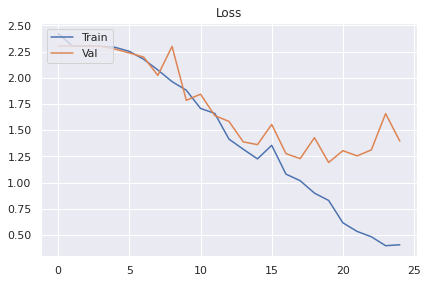

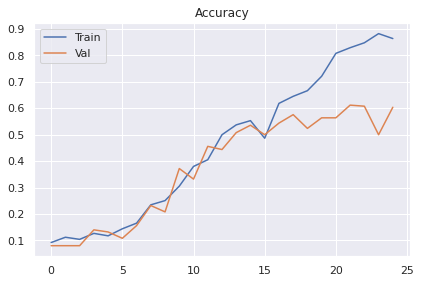

In [ ]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

Avec cette architecture là il est préférable de ne pas continuer l'entraînement, on a l'impression que la loss sur l'ensemble de validation a atteint un plateau et en augmentant le nombre d'époques on risque de faire de l'overfitting.

### Bilan des performances

Comme pour tous les modèles précédents, construisons la matrice de confusion :

Text(82.34, 0.5, 'predicted label')

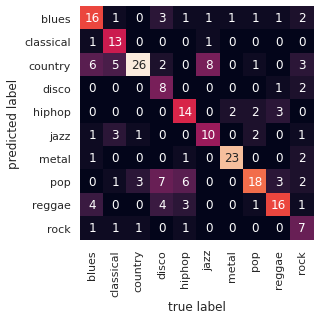

In [ ]:
sns.set()
predictions = model.predict(x_cnn_test)
mat = confusion_matrix(np.argmax(y_cnn_test, 1), np.argmax(predictions, 1))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=genres, yticklabels=genres)
plt.xlabel('true label')
plt.ylabel('predicted label')

On voit qu'avec cette approche les performances sont encore meilleurs. On a le sentiment qu'en optimisant encore notre CNN on pourrait grapiller encore quelques points.

C'est un résultat qui nous a surpris au départ mais qui finalement semble assez logique. Le spectrogramme d'un son caractérise ce son et contiendra toujours plus d'informations que celles que l'on peut éxtraire manuellement.

Un des inconvénients de l'utilisation des CNN est le manque d'interprétabilité. On n'a pas de moyens simples d'identifier les caractéristiques qui permettent de discrimer des sons, alors qu'avec random forest par exemple, on pouvait classer les features par ordre d'importance. C'est le fameux dilemme explicabilité/performances.

# Conclusion et analyse critique des résultats

Les premiers résultats que l'on obtient sont plutôt intéressants même si on pouvait ésperer obtenir de meilleurs performances.


*   **SVM :** 17.5%
*   **k-nn :** 29%
*   **RF :** 59.2%
*   **XGB :** 57.6%
*   **Neural Net :** 60.8%
*   **CNN :** 60.4%



Il y a certains points que l'on pourrait améliorer et qui peuvent peut-être expliquer ces performances :



*   Le choix des features est important mais il est aussi très subjectif. En pratique le choix des features doit se faire par des gens qui connaissent bien l'analyse musicale.

*   La classification de musiques par genre est une tâche qui est parfois difficile même pour un être humain. D'ailleurs il n'est pas rare d'observer des débats concernant le genre à laquelle une musique appartient.

*   Nous n'avions que 100 exemples de musiques par classe à disposition. C'est suffisant mais pour ce genre de tâches plus la base d'apprentissage est grande plus les performances sont bonnes.

*   Dans le cas du réseau convolutionnel sur les spectrogrammes, nous avons eu des difficultés pour éviter le surapprentissage. L'ajout de dropout n'a pas permis de résoudre le problème. Une option que l'on aurait pu experimenter est d'utiliser la data augmentation. Rajouter des pistes audio en modifiant légérement le signal par exemple en ajoutant du bruit. C'est une technique qui fonctionne surtout pour l'analyse d'images mais elle pourrait donner de bons résultats dans notre cas.



# Bibliographie



*   Music Genre Classification with Python, Towards data science, Parul Pandey : https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8
*   Zero Crossing Rate, Wikipédia : https://fr.wikipedia.org/wiki/Zero_Crossing_Rate
*   Cepstre, Wikipédia : https://fr.wikipedia.org/wiki/Cepstre
*   Spectral Rolloff point, Mathworks : https://www.mathworks.com/help/audio/ref/spectralrolloffpoint.html
*   Music genre classification with CNN, Towards data science, Lelan Roberts : https://towardsdatascience.com/musical-genre-classification-with-convolutional-neural-networks-ff04f9601a74
*   Construction and evaluation of a robust multifeature speech/music discriminator, Eric Scheirer & Malcolm Slaneyy : https://www.ee.columbia.edu/~dpwe/papers/ScheiS97-mussp.pdf
